In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.style import use as usestyle
from matplotlib import colors
import h5netcdf
%matplotlib inline
from datetime import datetime, timedelta
from pandas import date_range
from glob import glob

In [2]:
usestyle("paperplots.mplstyle")

In [3]:
from matplotlib import font_manager as fm
fontdir = "/home/ascheb/libfonts/*.ttf"
for fpath in glob(fontdir):
    print(fpath)
    fm.fontManager.addfont(fpath)

from matplotlib import rcParams
rcParams["figure.titlesize"] = 40
rcParams["axes.titlesize"] = 35
rcParams["axes.labelsize"] = 30
rcParams["xtick.labelsize"] = 27
rcParams["ytick.labelsize"] = 27

/home/ascheb/libfonts/LiberationSans-Italic.ttf
/home/ascheb/libfonts/LiberationMono-Bold.ttf
/home/ascheb/libfonts/LiberationSerif-Bold.ttf
/home/ascheb/libfonts/LiberationSerif-Regular.ttf
/home/ascheb/libfonts/LiberationSans-Regular.ttf
/home/ascheb/libfonts/LiberationSans-BoldItalic.ttf
/home/ascheb/libfonts/LiberationMono-Regular.ttf
/home/ascheb/libfonts/LiberationSerif-Italic.ttf
/home/ascheb/libfonts/LiberationSerif-BoldItalic.ttf
/home/ascheb/libfonts/LiberationMono-BoldItalic.ttf
/home/ascheb/libfonts/LiberationSans-Bold.ttf
/home/ascheb/libfonts/LiberationMono-Italic.ttf


In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
ftlist = date_range("2010-01-02-060000", "2010-01-03-060000", freq = "20min")
ftstrings = [i.strftime("%Y-%m-%d-%H%M%S") for i in ftlist]

In [7]:
controlws = xr.open_mfdataset([f"/moonbow/ascheb/les/2010/hires_control/processed_data/mergedvars_{i}.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")

In [8]:
nolakews = xr.open_mfdataset([f"/moonbow/ascheb/les/2010/hires_nolake/processed_data/mergedvars_{i}.nc" for i in ftstrings], preprocess = lambda x: x[["w", "SnowPrecipRate", "AggPrecipRate"]], combine = "nested", concat_dim = "time", engine = "h5netcdf")

In [9]:
controlws["time"] = ftlist
nolakews["time"] = ftlist

In [ ]:
print(controlws["SnowPrecipRate"][0, 500, 400].values)

In [ ]:
avgsnowrate_control = controlws["AggPrecipRate"].mean(dim = "time")+controlws["SnowPrecipRate"].mean(dim = "time")
avgsnowrate_nolake = nolakews["AggPrecipRate"].mean(dim = "time")+nolakews["SnowPrecipRate"].mean(dim = "time")

In [ ]:
print(avgsnowrate_control)

In [12]:
afile_control = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/gridconsts.nc") #This file is mainly for plotting; it has things like patch area, topography, and latitude/longitude which don't change
afile_nolake = xr.open_dataset("/moonbow/ascheb/les/2010/hires_nolake/gridconsts.nc") #ditto, but for nlh simulation

NameError: name 'avgsnowrate_control' is not defined

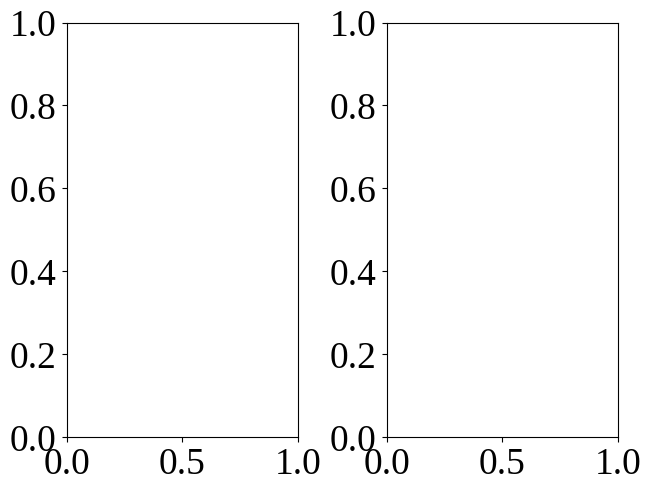

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pcolormesh(avgsnowrate_control, cmap = "Blues", vmin = 0, vmax = 4)
ax2.pcolormesh(avgsnowrate_nolake, cmap = "Blues", vmin = 0, vmax = 4)

In [14]:
ix0 = 380; iy0 = 615 #Northwest side of the "downwind of lake erie" box, at the center of the downwind shore
x0 = afile_control["x"].isel(x = ix0); y0 = afile_control["y"].isel(y = iy0); dxy = np.diff(afile_control["x"])[0]
width = 380000; length = 105000 #m, dimensions of the box
tarray = np.arange(0, length+1, dxy); narray = np.arange(-width/2, width/2+1, dxy) #Coordinates of the box in tangent (long-axis) and normal (short-axis) directions. Normal is negative and positive (northeast and southwest), while tangent is only positive (to the right)
tmesh, nmesh = np.meshgrid(tarray, narray)
print(tmesh)
print(nmesh)
angle = np.pi/180*(-70) #Angle of the long axis of the box, with respect to the horizontal
xbox = x0.values+np.cos(angle)*tmesh-np.sin(angle)*nmesh
ybox = y0.values+np.sin(angle)*tmesh+np.cos(angle)*nmesh
lakebox = xr.DataArray(coords = {"y": (("normal", "tangent"), ybox), "x": (("normal", "tangent"), xbox), "normal": narray, "tangent": tarray}, dims = ["normal", "tangent"])

[[     0.   1000.   2000. ... 103000. 104000. 105000.]
 [     0.   1000.   2000. ... 103000. 104000. 105000.]
 [     0.   1000.   2000. ... 103000. 104000. 105000.]
 ...
 [     0.   1000.   2000. ... 103000. 104000. 105000.]
 [     0.   1000.   2000. ... 103000. 104000. 105000.]
 [     0.   1000.   2000. ... 103000. 104000. 105000.]]
[[-190000. -190000. -190000. ... -190000. -190000. -190000.]
 [-189000. -189000. -189000. ... -189000. -189000. -189000.]
 [-188000. -188000. -188000. ... -188000. -188000. -188000.]
 ...
 [ 188000.  188000.  188000. ...  188000.  188000.  188000.]
 [ 189000.  189000.  189000. ...  189000.  189000.  189000.]
 [ 190000.  190000.  190000. ...  190000.  190000.  190000.]]


In [15]:
print(lakebox)

<xarray.DataArray (normal: 381, tangent: 106)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    y        (normal, tangent) float64 1.516e+03 576.5 ... 3.376e+04 3.282e+04
    x        (normal, tangent) float64 -2.97e+05 -2.967e+05 ... 9.595e+04
  * normal   (normal) float64 -1.9e+05 -1.89e+05 -1.88e+05 ... 1.89e+05 1.9e+05
  * tangent  (tangent) float64 0.0 1e+03 2e+03 ... 1.03e+05 1.04e+05 1.05e+05


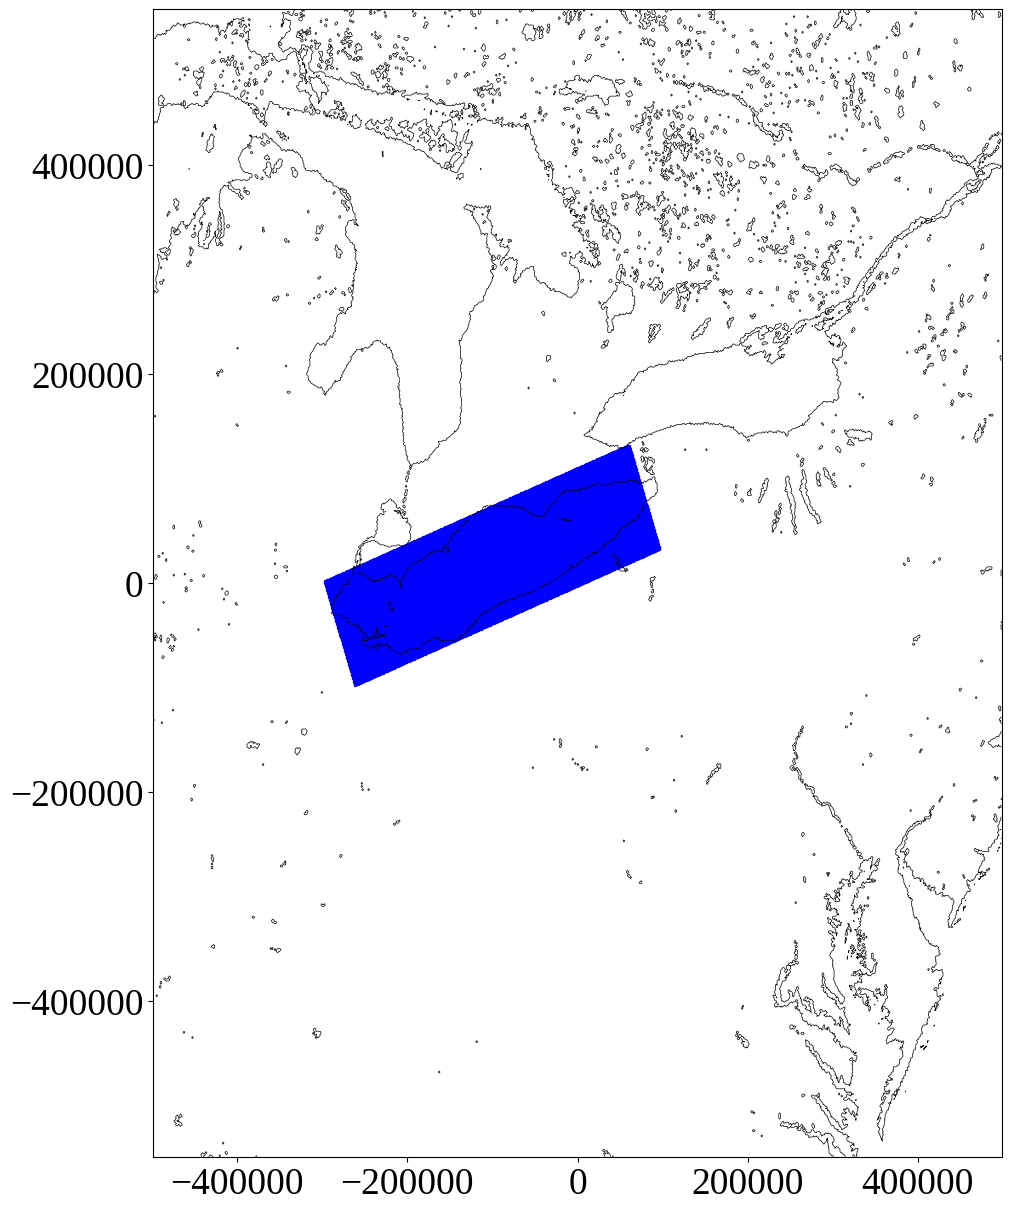

In [16]:
plt.figure(figsize = (10, 12))
plt.contour(afile_control["x"], afile_control["y"], afile_control["Patch"][1,:,:], levels = [0.99], colors = "black", linewidths = 0.5)
plt.scatter(lakebox["x"], lakebox["y"], color = "blue", s = 2)

In [17]:
lakebox["lat"] = afile_control["lat2d"].interp(x = lakebox["x"], y = lakebox["y"])
lakebox["lon"] = afile_control["lon2d"].interp(x = lakebox["x"], y = lakebox["y"])
lakebox["lakemask"] = xr.DataArray(np.where(afile_control["Patch"][0,:,:].interp(x = lakebox["x"], y = lakebox["y"])>0.99, 1, np.nan), coords = lakebox.coords, dims = lakebox.dims)

In [ ]:
lakebox.to_netcdf("lakebox.nc")

In [ ]:
print(lakebox["lakemask"])

In [18]:
lakemean_control_timeseries = (controlws.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "tangent", skipna = True)
lakemean_nolake_timeseries = (nolakews.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "tangent", skipna = True)

In [ ]:
plt.pcolormesh(lakebox["tangent"], lakebox["normal"], lakebox["lakemask"], vmin = 0, vmax = 1, cmap = "Blues")

In [ ]:
print(lakemean_control_timeseries["w"])

In [ ]:
print(ftstrings[12:61:24])

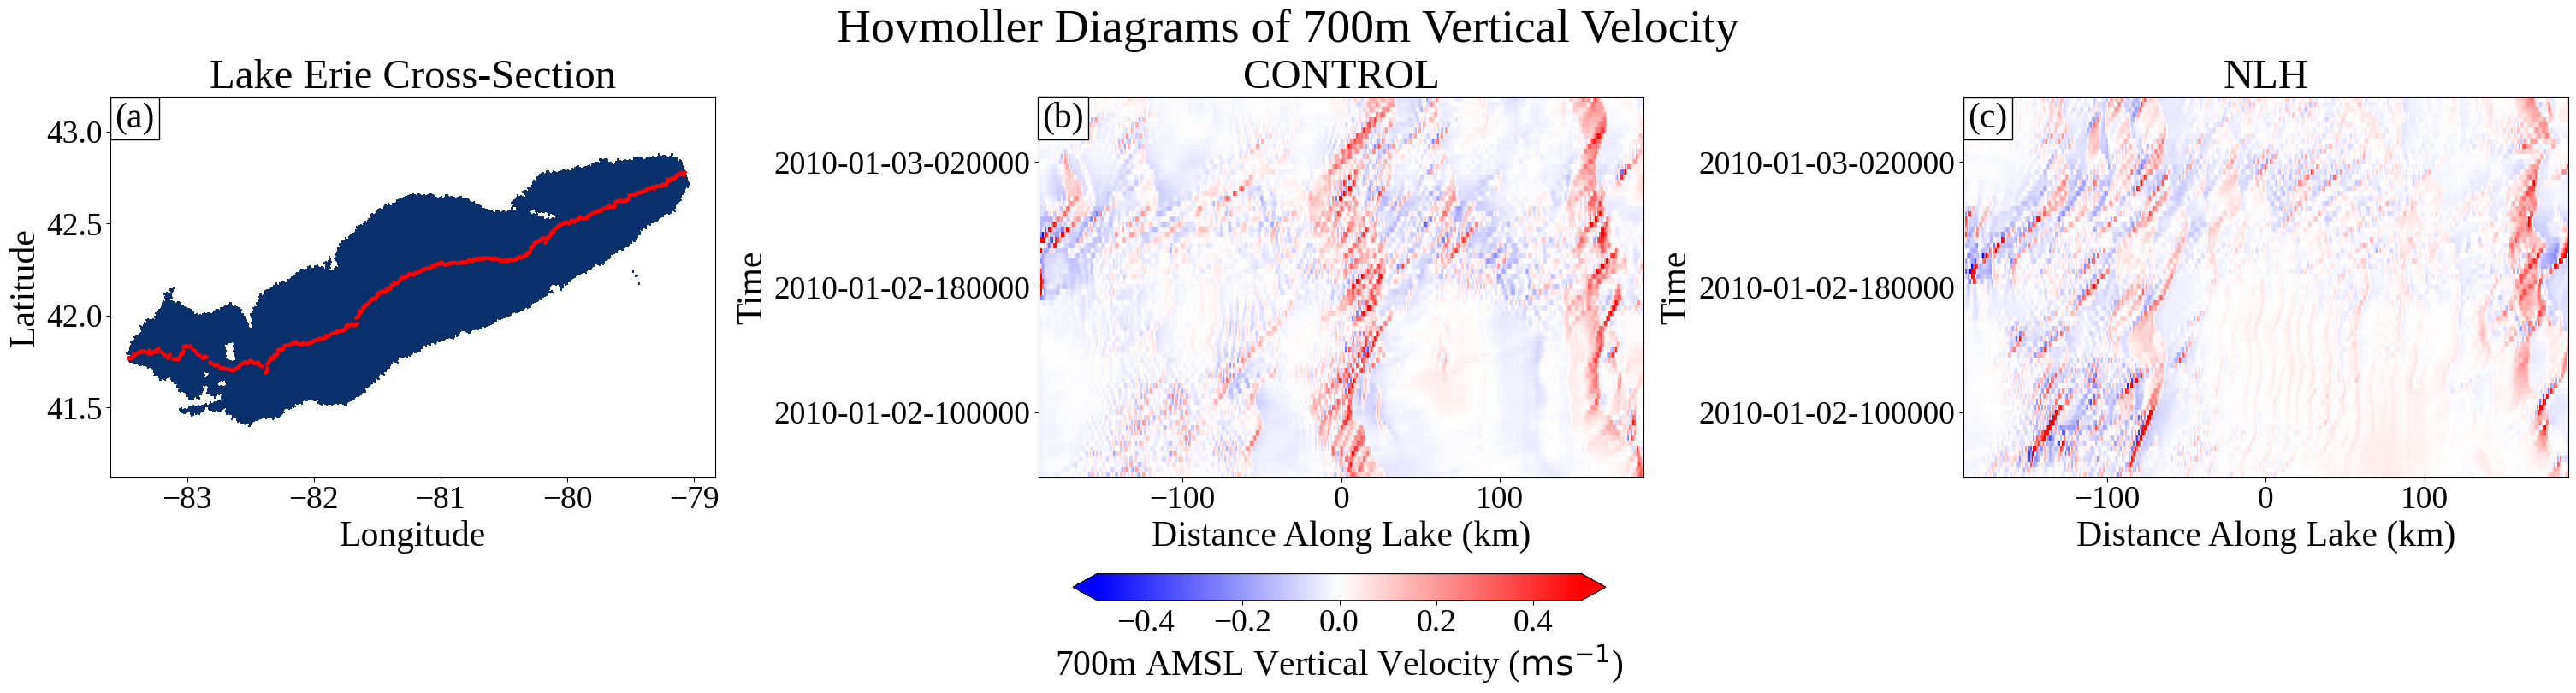

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 8))
fig.suptitle("Hovmoller Diagrams of 700m Vertical Velocity")
axlabels = ["(a)", "(b)", "(c)"]
for i, ax in enumerate(fig.get_axes()):
    ax.annotate(axlabels[i], (0.04, 0.92), xycoords = "axes fraction", color = "black", fontsize = 30, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 1)
ax1.pcolormesh(lakebox["lon1d"], lakebox["lat1d"], lakebox["lakemask"], vmin = 0, vmax = 1, cmap = "Blues", zorder = 0)
ax1.scatter((lakebox["lon1d"]*lakebox["lakemask"]).mean(dim = "tangent", skipna = True), (lakebox["lat1d"]*lakebox["lakemask"]).mean(dim = "tangent", skipna = True), color = "red", s = 6, zorder = 1)
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")
ax1.set_title("Lake Erie Cross-Section")
for ax in (ax2, ax3):
    ax.set_xlabel("Distance Along Lake (km)")
    ax.set_ylabel("Time")
    ax.set_yticks(ticks = [12,36,60], labels = ftstrings[12:61:24])
ax2.set_title("CONTROL")
ax3.set_title("NLH")
whov = ax2.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), lakemean_control_timeseries["w"].sel(z = 700, method = "nearest"), vmin = -0.5, vmax = 0.5, cmap = "bwr", zorder = 0)
ax3.pcolormesh(lakemean_control_timeseries["normal"]/1000, np.arange(0, len(ftstrings), 1), lakemean_nolake_timeseries["w"].sel(z = 700, method = "nearest"), vmin = -0.5, vmax = 0.5, cmap = "bwr", zorder = 0)
cbar = fig.colorbar(whov, ax  = [ax1, ax2, ax3], orientation = "horizontal", fraction = 0.07, extend = "both"); cbar.set_label("700m AMSL Vertical Velocity ($\mathrm{m s^{-1}}$)")
fig.savefig("PaperFigs/vertvelocity_hov.png")

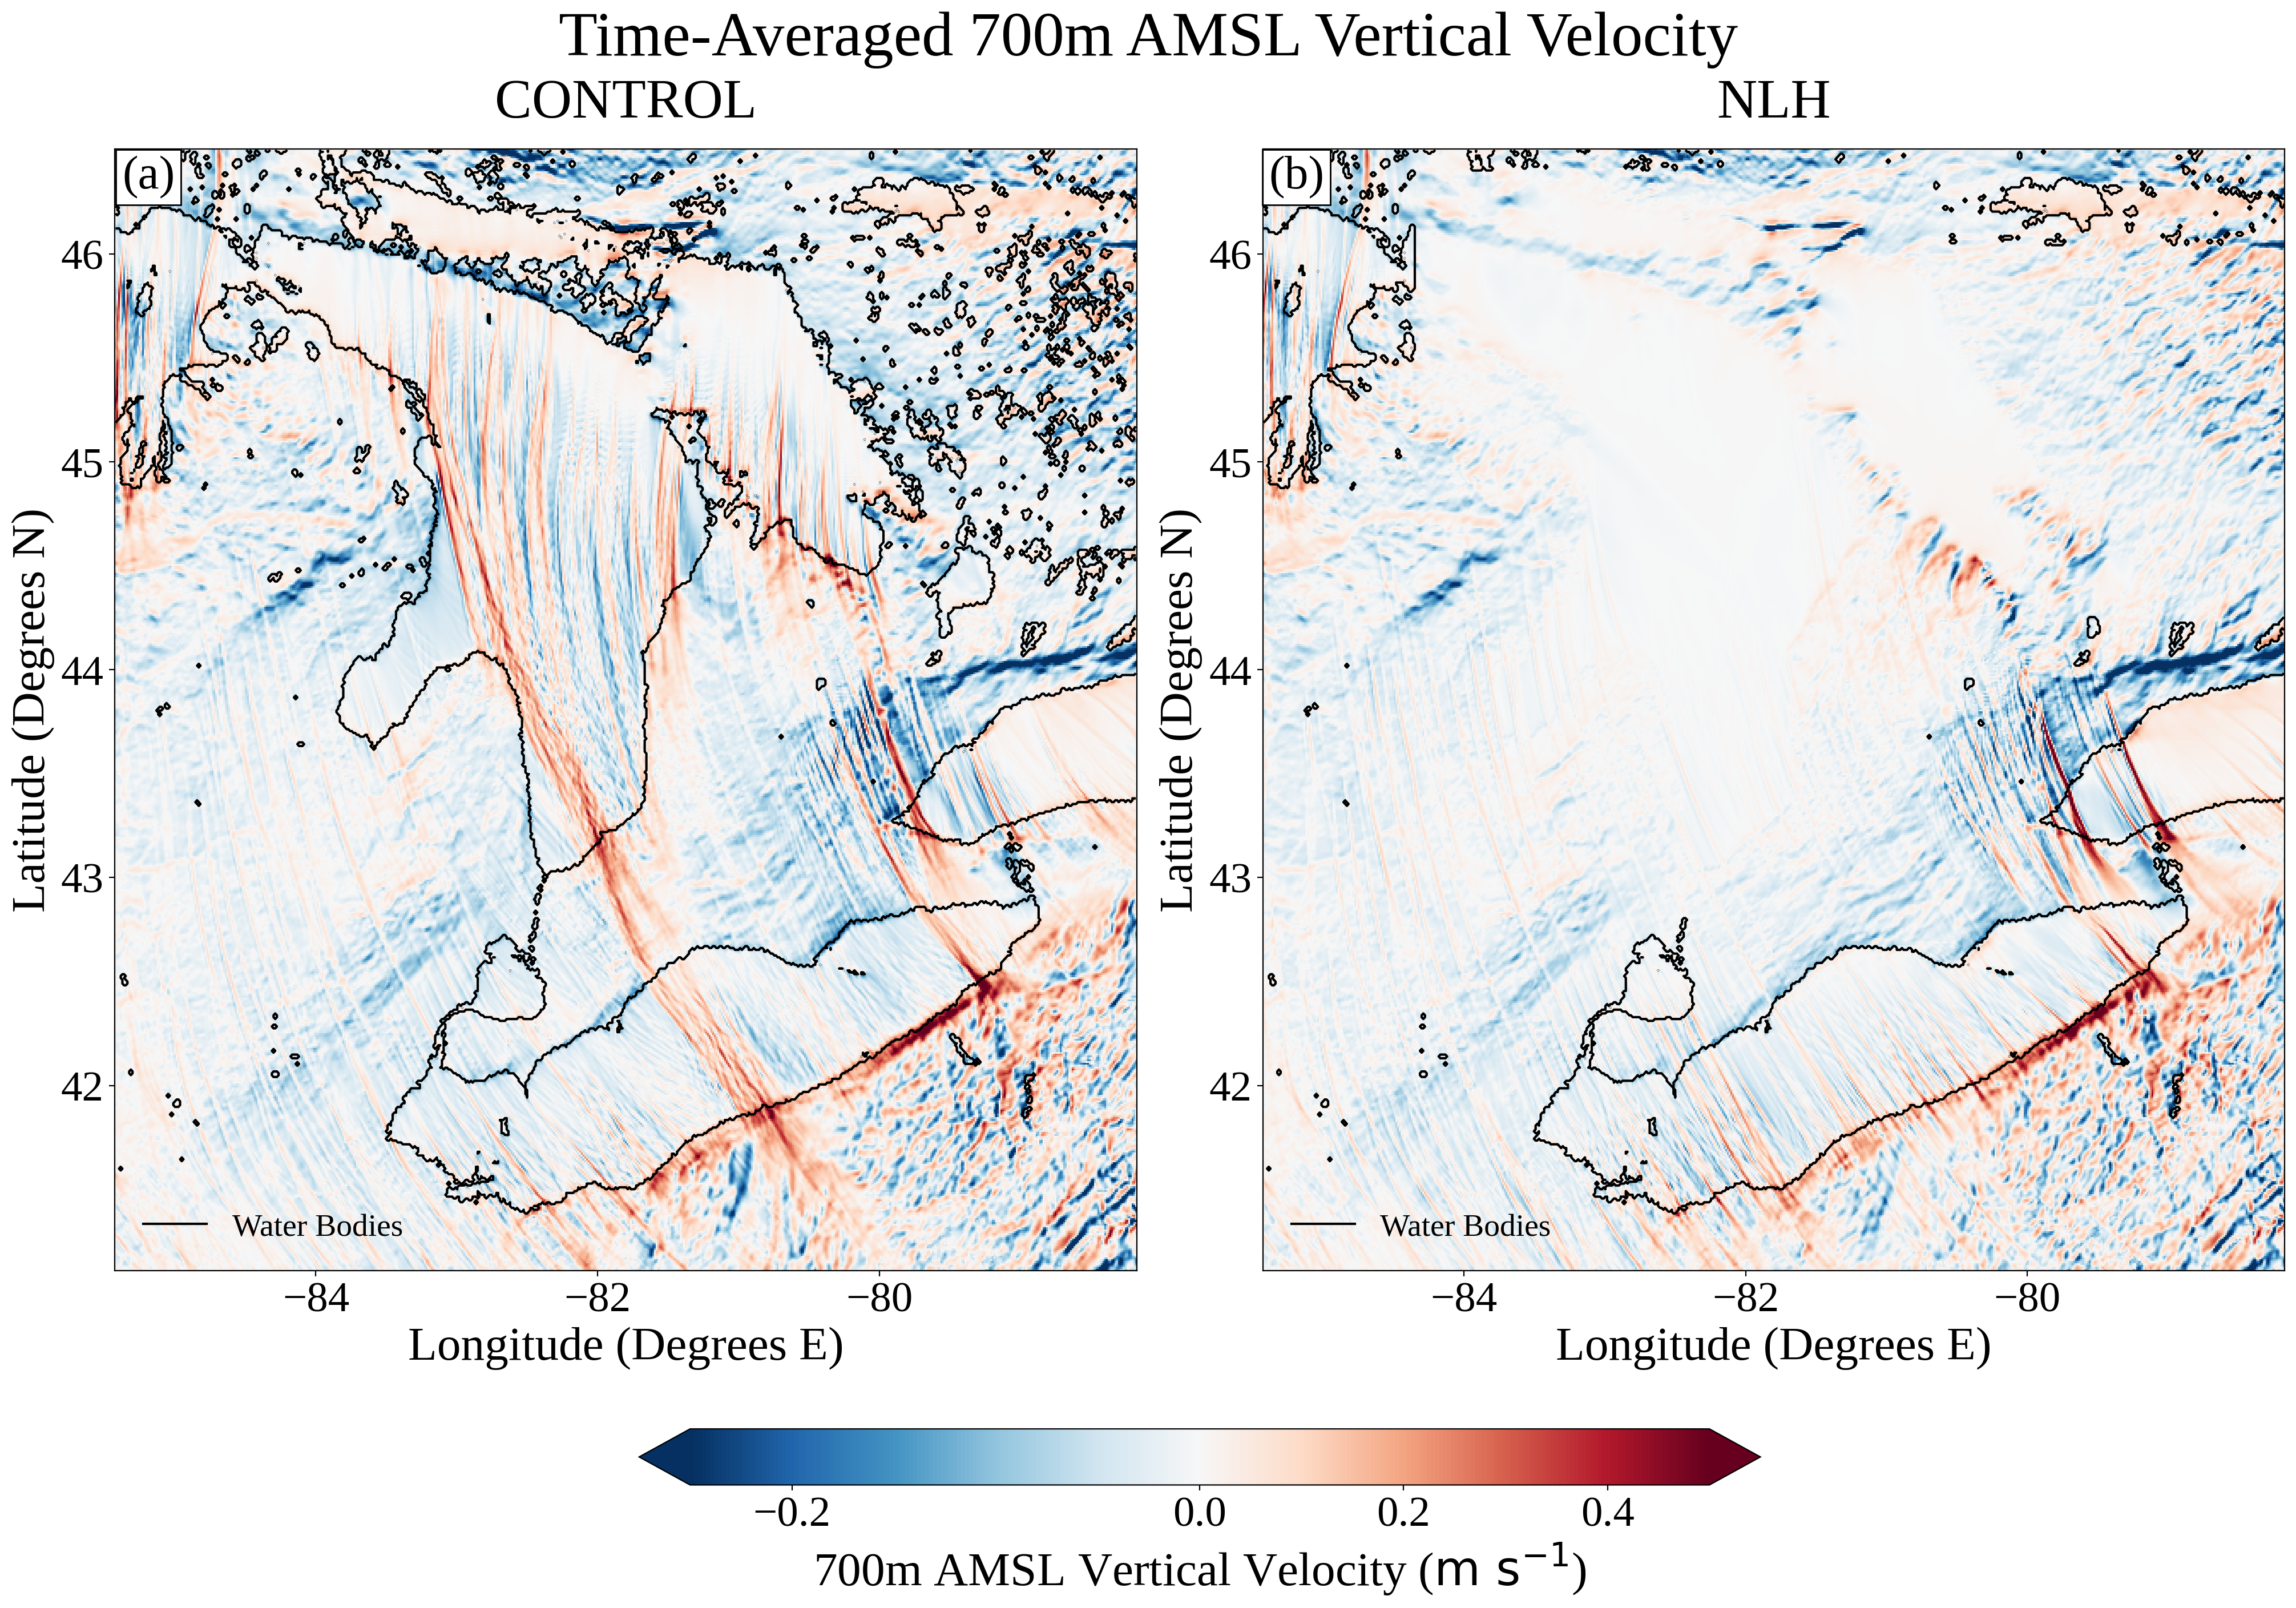

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 14), dpi = 200, layout = "constrained")
axlabels = ["(a)", "(b)"]
for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel("Longitude (Degrees E)")
    ax.set_ylabel("Latitude (Degrees N)")
    ax.set_yticks([41, 42, 43, 44, 45, 46])
    ax.set_xticks([-84, -82, -80])
    ax.annotate(axlabels[i], (0.033, 0.965), xycoords = "axes fraction", color = "black", fontsize = 30, horizontalalignment = "center", bbox = {"edgecolor": "black", "linewidth": 1, "facecolor": "white"}, zorder = 2)
    # ax.pcolormesh(afile_control["lon1d"][50:650], afile_control["lat1d"][450:1050], afile_control["Topo"][450:1050, 50:650], cmap = "gist_earth", norm = MidpointNormalize(vmin = -20, vcenter = 0, vmax = 1000), zorder = 0)
    # ax.pcolormesh(afile_control["lon1d"], afile_control["lat1d"], afile_control["Patch"][0,:,:].where(afile_control["Patch"][0,:,:]==1), color = "Navy", zorder = 0)
ax1.set_title("CONTROL", fontfamily = "Liberation Serif", y = 1.02)
ax2.set_title("NLH", fontfamily = "Liberation Serif", y = 1.02)
ax1.contour(afile_control["lon1d"].isel(x = slice(50, 650)), afile_control["lat1d"].isel(y = slice(450, 1050)), afile_control["Patch"].isel(patch = 1, x = slice(50, 650), y = slice(450, 1050)), levels = [0.99], colors = "black", linewidths = 1.5, zorder = 1)
ax2.contour(afile_control["lon1d"].isel(x = slice(50, 650)), afile_control["lat1d"].isel(y = slice(450, 1050)), afile_nolake["Patch"].isel(patch = 1, x = slice(50, 650), y = slice(450, 1050)), levels = [0.99], colors = "black", linewidths = 1.5, zorder = 1)
walt = 700 #m AMSL, altitude at which to evalute w
fig.suptitle(f"Time-Averaged 700m AMSL Vertical Velocity")
from matplotlib.lines import Line2D
fakecontour = Line2D([], [], color = "black", linewidth = 1.5, label = "Water Bodies")
wmp = ax1.pcolormesh(afile_control["lon1d"].isel(x = slice(50, 650)), afile_control["lat1d"].isel(y = slice(450, 1050)), controlws["w"].mean(dim = "time").sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax2.pcolormesh(afile_control["lon1d"].isel(x = slice(50, 650)), afile_control["lat1d"].isel(y = slice(450, 1050)), nolakews["w"].mean(dim = "time").sel(z = walt, method = "nearest").isel(x = slice(50, 650), y = slice(450, 1050)), cmap = "RdBu_r", norm = MidpointNormalize(vmin = -0.25, vmax = 0.5, vcenter = 0), zorder = 0)
ax1.legend(loc = "lower left", fontsize = 20, handles = [fakecontour], labelcolor = "black")
ax2.legend(loc = "lower left", fontsize = 20, handles = [fakecontour], labelcolor = "black")
cbar = fig.colorbar(wmp, ax = [ax1, ax2], orientation = "horizontal", fraction = 0.05, extend = "both"); cbar.set_label(f"{walt}m AMSL Vertical Velocity ($\mathrm{{m \ s^{{-1}}}}$)")
fig.savefig(f"PaperFigs/wplan_composite.png")

In [ ]:
controlws_laketime = (controlws.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "time")
nolakews_laketime = (nolakews.interp(x = lakebox["x"], y = lakebox["y"])*lakebox["lakemask"]).mean(dim = "time")

In [ ]:
print(controlws_laketime["w"].sel(z=700, method = "nearest").where((controlws_laketime["w"].sel(z=700, method = "nearest")>0.5)*(controlws_laketime["w"].sel(z=700, method = "nearest")<2)).mean(skipna = True).values)
print(nolakews_laketime["w"].sel(z=700, method = "nearest").where((nolakews_laketime["w"].sel(z=700, method = "nearest")>0.5)*(nolakews_laketime["w"].sel(z=700, method = "nearest")<2)).mean(skipna = True).values)

In [ ]:
control_lakedist = lakebox["normal"].where(afile_control["Patch"][0,:,:].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]) > 0.99).dropna(dim = "normal").values

In [ ]:
plt.figure()
plt.plot(afile_control["Patch"][0,:,:].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), color = "blue")

In [ ]:
print(lakebox["lakemask"][:,53].sel(normal = control_lakedist))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 8))
zbnds = slice(0, 60, 1)
fig.suptitle("Cross-Sections of Vertical Velocity at 1800 LT")
for ax in (ax2, ax3):
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_ylim(0, 2000)
    ax.set_ylabel("Altitude (m AMSL")
    ax.set_xlabel("Distance Along Lake (km)")
    ax.fill_between(lakebox["normal"], afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), 0, color = "tan")
    ax.fill_between(lakebox["normal"], afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), 1/2*afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), where = (afile_control["Patch"][0,:,:].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]) > 0.99), color = "blue")
ax1.pcolormesh(lakebox["lon1d"], lakebox["lat1d"], lakebox["lakemask"], cmap = "Blues", vmin = 0, vmax = 1)
ax1.scatter(lakebox["lon1d"][:,53], lakebox["lat1d"][:,53], color = "red", s = 2)
fakecontour = Line2D([], [], color = "red", linewidth = 2, label = "Cross-Section")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.legend(handles = [fakecontour])
wmp = ax2.pcolormesh(lakebox["normal"], afile_control["z"].isel(z = zbnds), afile_control["w"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]).isel(z = zbnds), norm = MidpointNormalize(vmin = -2, vmax = 4, vcenter = 0), cmap = "bwr")
ax3.pcolormesh(lakebox["normal"], afile_control["z"].isel(z = zbnds), afile_nolake["w"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]).isel(z = zbnds), norm = MidpointNormalize(vmin = -2, vmax = 4, vcenter = 0), cmap = "bwr")
cbar1 = fig.colorbar(wmp, ax = fig.get_axes(), orientation = "horizontal", fraction = 0.05, extend = "both"); cbar1.set_label("Vertical Velocity ($\mathrm{m s^{-1}}$)")

In [ ]:
plt.figure(figsize = (6, 3))
# plt.scatter(control_lakedist, np.sin(control_lakedist/(100000)), color = "blue", s = 1)
plt.fill_between(lakebox["normal"], afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), 0, color = "tan")
plt.fill_between(lakebox["normal"], afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), 1/2*afile_control["Topo"].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]), where = (afile_control["Patch"][0,:,:].interp(x = lakebox["x"][:,53], y = lakebox["y"][:,53]) > 0.99), color = "blue")

In [ ]:
print(afile_control["SensibleHeatFlux"])

In [ ]:
print((lakebox["lakemask"]*afile_control["SensibleHeatFlux"].interp(x = lakebox["x"], y = lakebox["y"])).mean())
print((lakebox["lakemask"]*afile_nolake["SensibleHeatFlux"].interp(x = lakebox["x"], y = lakebox["y"])).mean())

In [ ]:
plt.figure(figsize = (10, 11))
plt.pcolormesh((np.gradient(afile_control["u"].sel(z = 600, method = "nearest").values, 1000, axis = 1)+np.gradient(afile_control["v"].sel(z = 600, method = "nearest").values, 1000, axis = 0))[450:1050,50:650], cmap = "BrBG", vmin = -10**(-3), vmax = (10**(-3)))

In [ ]:
afileraw_control = xr.open_dataset("/moonbow/ascheb/les/2010/hires_control/rams_output/a-A-2010-01-02-230000-g1.h5")

In [ ]:
# horizdivraw_control = np.gradient(afileraw_control["u"]
print(afileraw_control["WC"])

In [ ]:
plt.figure(figsize = (10,11))
plt.pcolormesh(afileraw_control["WC"].isel(phony_dim_2 = , phony_dim_1 = slice(650,950), phony_dim_0 = slice(450,650)), vmin = -2, vmax = 2, cmap = "bwr")

In [ ]:
print(afile_control["w"])